<a href="https://colab.research.google.com/github/sjtao98/NUCL610/blob/main/Project2/NUCL610_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import math as m
import cmath as cm
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

### Part 0
Analytical solution (from project 1)

In [53]:
def _analytical(case, lam_init):
    def _init_global():
        if case == 'UO2':
            para_dict = {
                "sig_a1": 8.873837e-3,
                "nusig_f1": 5.424022e-3,
                "sig_tr1": 2.332139e-1,
                "sig_12": 1.592122e-2,
                "sig_a2": 6.377025e-2,
                "nusig_f2": 9.959442e-2,
                "sig_tr2": 8.918111e-1,
                "sig_21": 0,
                "h": 100
            }
        elif case == 'MOX':
            para_dict = {
                "sig_a1": 1.406811e-2,
                "nusig_f1": 1.126274e-2,
                "sig_tr1": 2.219159e-1,
                "sig_12": 1.147102e-2,
                "sig_a2": 2.691350e-1,
                "nusig_f2": 4.577393e-1,
                "sig_tr2": 1.043375e+0,
                "sig_21": 0,
                "h": 100
            }
        return para_dict;

        
    #Ref: slides #4 page 3
    def _cn(Bsquare, h):
        if Bsquare > 0:
            return m.cos(m.sqrt(Bsquare) * h)
        elif Bsquare == 0:
            return 1;
        else:
            return m.cosh(abs(cm.sqrt(Bsquare)) * h)
    
    def _sn(Bsquare, h):
        if Bsquare > 0:
            return m.sin(m.sqrt(Bsquare) * h) / m.sqrt(Bsquare)
        elif Bsquare == 0:
            return h;
        else:
            return m.sinh(abs(cm.sqrt(Bsquare)) * h) / abs(cm.sqrt(Bsquare))
    
    #Ref: slides #4 page 7 
    def _B1square(p, q):
        return (-p + m.sqrt(p**2 + 4 * q)) / 2
    
    def _B2square(p, q):
        return (-p - m.sqrt(p**2 + 4 * q)) / 2
    
    def _f(lam):
        #initalize input variables
        parameter = _init_global()
        sig_a1 = parameter["sig_a1"]
        nusig_f1 = parameter["nusig_f1"]
        sig_tr1 = parameter["sig_tr1"]
        sig_12 = parameter["sig_12"]
        sig_a2 = parameter["sig_a2"]
        nusig_f2 = parameter["nusig_f2"]
        sig_tr2 = parameter["sig_tr2"]
        sig_21 = parameter["sig_21"]
        h  = parameter["h"]
        
        #find D1, D2, sig_r1, sig_r2
        D1 = 1.0 / 3 / sig_tr1;
        D2 = 1.0 / 3 / sig_tr2;
        sig_r1 = sig_a1 + sig_12;
        sig_r2 = sig_a2 + sig_21;
        
        #computation
        p = sig_r2 / D2 + (sig_r1 - lam * nusig_f1) / D1
        q = (lam * nusig_f2 + sig_21) * sig_12 - sig_r2 * (sig_r1 - lam * nusig_f1)
        q = q / D1 / D2
        
        B1s = _B1square(p, q)
        B2s = _B2square(p, q)
        
        sn1 = _sn(B1s, h)
        cn1 = _cn(B1s, h)
        sn2 = _sn(B2s, h)
        cn2 = _cn(B2s, h)
        
        left = (D2 * B1s + sig_r2) * (2 * sn1 * D1 * B1s - cn1) * (-2 * sn2 * D2 * B2s + cn2)
        right = (D2 * B2s + sig_r2) * (-2 * sn2 * D1 * B2s + cn2) * (2 * sn1 * D2 * B1s - cn1)
        
        return left - right
 
    #plotting phi_1(x) and phi_2(x)
    def _phi(lam, lam_init):
        #initalize input variables
        parameter = _init_global()
        sig_a1 = parameter["sig_a1"]
        nusig_f1 = parameter["nusig_f1"]
        sig_tr1 = parameter["sig_tr1"]
        sig_12 = parameter["sig_12"]
        sig_a2 = parameter["sig_a2"]
        nusig_f2 = parameter["nusig_f2"]
        sig_tr2 = parameter["sig_tr2"]
        sig_21 = parameter["sig_21"]
        h  = parameter["h"]
        
        #find D1, D2, sig_r1, sig_r2
        D1 = 1.0 / 3 / sig_tr1;
        D2 = 1.0 / 3 / sig_tr2;
        sig_r1 = sig_a1 + sig_12;
        sig_r2 = sig_a2 + sig_21;
        
        #computation
        p = sig_r2 / D2 + (sig_r1 - lam * nusig_f1) / D1
        q = (lam * nusig_f2 + sig_21) * sig_12 - sig_r2 * (sig_r1 - lam * nusig_f1)
        q = q / D1 / D2
        
        B1s = _B1square(p, q)
        B2s = _B2square(p, q)
        
        sn1 = _sn(B1s, h)
        cn1 = _cn(B1s, h)
        sn2 = _sn(B2s, h)
        cn2 = _cn(B2s, h)
        
        C10 = -2 * sn2 * D2 * B2s + cn2
        C20 = 2 * sn1 * D2 * B1s - cn1
        
        C20 = C20/C10;
        C10 = 1;
        
        num = h*10+1 #6
        X = np.linspace(0, h, num)
        phi = np.zeros([num,2])
        
        #file1 = open("%s.txt" %(case+"_phi_result"),"w")
        scale = (D2 * B1s + sig_r2) * C10 * _cn(B1s, X[0]) + \
                (D2 * B2s + sig_r2) * C20 * _cn(B2s, X[0])
        for i in range(len(X)):
            a1 = (D2 * B1s + sig_r2) * C10 * _cn(B1s, X[i])
            a2 = (D2 * B2s + sig_r2) * C20 * _cn(B2s, X[i])
            phi[i,0] = a1 + a2
            
            b1 = sig_12 * C10 * _cn(B1s, X[i])
            b2 = sig_12 * C20 * _cn(B2s, X[i])
            phi[i,1] = b1 + b2
            
            phi[i,0] = phi[i,0] / scale
            phi[i,1] = phi[i,1] / scale
            #file1.write(str(X[i]) + "  " + str(phi[i,0])  + "  " + str(phi[i,1]))
            #file1.write("\n")
        
        #file1.close()
        """
        plt.plot(X, phi[:,0], label = "$\phi_1(x)$")
        plt.plot(X, phi[:,1], label = "$\phi_2(x)$")
        plt.yscale("linear")
        plt.xlabel('x/cm')
        plt.ylabel('$\phi(x)$')
        plt.legend()
        plt.show()
        """
        return (X, phi, C10, C20)
    
    lamguess = lam_init
    lam = fsolve(_f, lamguess)
    s = "Analytically Estimated k-eff for " + case + ": " + str(1/lam);
    print(s)
    X, phi, C10, C20 = _phi(lam, lam_init)

    return (X, phi, 1/lam[0])

### Part A
Develop a one-dimensional (slab) Nodal Expansion Method (NEM) code for steady state neutronic diffusion theory

In [54]:
 #orthogonal basis polynomials for NEM
def _p0(x):
    return 1

def _p1(x):
    return x

def _p2(x):
    return (3 * x ** 2 - 1) / 2

def _p3(x):
    return (5 * x ** 3 - 3 * x) / 5

def _p4(x):
    return (35 * x ** 4 - 30 * x ** 2 + 3) / 8

def _dp0(x):
    return 0

def _dp1(x):
    return 1

def _dp2(x):
    return 3 * x

def _dp3(x):
    return 5 * _p2(x) + 1

def _dp4(x):
    return 7 * _p3(x) + 3 * x

def _ddp0(x):
    return 0

def _ddp1(x):
    return 0

def _ddp2(x):
    return 3

def _ddp3(x):
    return 15 * x

def _ddp4(x):
    return 35 * _p2(x) + 10

# bc types
def _albedo(bc):
    if bc == 0:        #Reflective
        return 0
    elif bc == 1:      #Vacuume
        return 0.5
    elif bc == 2:      #Extrapolation
        return 0.4695

#non-dimensional xi in [-1, 1]
def _xi(ui, ul, ur):
    hu = ur - ul
    x = (2 * ui - (ur + ul)) / hu
    return (hu, x)

In [55]:
def _GeoInit(CASE, THICKNESS, MESH):
  """
  case: array of material eg: [UO2, MOX, UO2, MOX, UO2]
  THICKNESS: the thickness array of each region
  MESH: total number of meshes in all region
  """
  def _parameter_init():
    para_dict = {
        'UO2':{
        "sig_a1": 8.873837e-3,
        "nusig_f1": 5.424022e-3,
        "sig_tr1": 2.332139e-1,
        "sig_12": 1.592122e-2,
        "sig_a2": 6.377025e-2,
        "nusig_f2": 9.959442e-2,
        "sig_tr2": 8.918111e-1,
        "sig_21": 1e-15, #0
        },
        'MOX':{
        "sig_a1": 1.406811e-2,
        "nusig_f1": 1.126274e-2,
        "sig_tr1": 2.219159e-1,
        "sig_12": 1.147102e-2,
        "sig_a2": 2.691350e-1,
        "nusig_f2": 4.577393e-1,
        "sig_tr2": 1.043375e+0,
        "sig_21": 1e-15, #0
        }
    }
    return para_dict
  
  para_dict = _parameter_init()
  if len(CASE) != len(THICKNESS):
      print("Inproper input, quit\n")
      exit(0)
  region = len(CASE)
  nmesh = max(region, MESH) #make sure mesh >= region
  geosize = sum(THICKNESS)     #total length of the core
  u = np.linspace(0, geosize, nmesh)
  nodenum = nmesh-1
  h = np.zeros(nodenum) #size of each mesh block
  ua = np.zeros(nodenum) # cm of center of each mesh
  for i in range(nodenum):
    h[i] = u[i+1] - u[i]
    ua[i] = u[i] + h[i] / 2

  length = np.zeros(region)
  length[0] = THICKNESS[0]
  for i in range(1, region):
      length[i] = length[i-1] + THICKNESS[i]
  
  #prepare cross-section 2d arrays
  Siga   = np.zeros(shape=(nodenum,2)) # 1, 2
  Sigtr  = np.zeros(shape=(nodenum,2))
  nuSigf = np.zeros(shape=(nodenum,2))
  Sigss  = np.zeros(shape=(nodenum,2,2)) # 12, 21
  Chi    = np.zeros(shape=(nodenum,2)) 
  D      = np.zeros(shape=(nodenum,2))
  
  r = 0
  for i in range(nodenum):
      #determing material based on the upper bound of each node
      if u[i+1] <= length[r]:
          case = CASE[r]
      if u[i+1] == length[r]:
          r = r + 1
      Siga[i][0] = para_dict[case]["sig_a1"]
      Siga[i][1] = para_dict[case]["sig_a2"]
      Sigtr[i][0] = para_dict[case]["sig_tr1"]
      Sigtr[i][1] = para_dict[case]["sig_tr2"]
      nuSigf[i][0] = para_dict[case]["nusig_f1"]
      nuSigf[i][1] = para_dict[case]["nusig_f2"]
      Sigss[i][0][0] = 1
      Sigss[i][0][1] = para_dict[case]["sig_12"]
      Sigss[i][1][0] = para_dict[case]["sig_21"]
      Sigss[i][1][1] = 1 
      D[i][0] = 1/3.0/Sigtr[i][0]
      D[i][1] = 1/3.0/Sigtr[i][1]
      Chi[i][0] = 0.99999
      Chi[i][1] = 1 - Chi[i][0]
  return (u, h, ua, Siga, Sigtr, nuSigf, Sigss, D, Chi)

In [56]:
def _NEM1D(avgphi, u, h, Siga, Sigtr, nuSigf, Sigss, D, Chi, nodenum, lamd, fcW, fcE, bconl, bconr):
  NDFmin = 1.0E-3
  NDFmax = 1.0E3
  def _one_node_left(h, avgphil, fdl, l, bcW, lamd):
      """
      q = [q0, q1, q2] (here all zero)
      phi: flux array
      bconl: boundary condition, 0: reflective, 1: vacuum, 2: extrapolation
      a0, a1, a2, a3, a4: G*1 array
      """
      #prepare matrices Abarn, betan, Kn, node size for node
      Dp = np.diag([D[l][0],D[l][1]])
      TS = [[Siga[l][0]+Sigss[l][0][1], Sigss[l][1][0]], [Sigss[l][0][1], Siga[l][1]+Sigss[l][1][0]]]
      chi = [[Chi[l][0]], [Chi[l][1]]]
      F = [[nuSigf[l][0]], [nuSigf[l][1]]]
      chiF = chi @ np.transpose(F)

      hd = h[l] / 2
      Kp = hd * hd / 4 * la.inv(Dp)
      beta = 2 / hd * Dp
      Mba = TS - lamd * chiF
      Abar = Kp @ Mba
      
      #even order
      a0 = avgphil
      a2 = la.inv(10.5 * np.diag([1,1]) + Abar) @ (3.5 * Abar @ a0)
      a4 = 1/35 * (Abar @ a2)
      
      #odd order
      alpbc = bcW
      alpha_l = np.diag([alpbc, alpbc])
      gamma_l = alpha_l @ np.diag(fdl)
      
      a024 = a0 + a2 + a4
      a24  = 3 * a2 + 10 * a4
      
      Ca3  = la.inv(6 * beta + gamma_l)
      C024 = Ca3 @ gamma_l
      C24  = Ca3 @ beta
      C1   = C024 + C24
      
      a1 = la.inv(15 * C1 @ Abar) @ (-15 * (C024 @ a024 + C24 @ a24))
      a3 = -C1 @ a1 - C24 @ a24 - C024 @ a024
      
      Jl = -beta @ (a1 + 3 * a2 + 6 * a3 + 10 * a24)

      for g in range(2):
        if Jl[g] <= 0:
          NDFR[g] = NDFmin
        else:
          deltaphi = Jl[g] / beta[g][g]
          philoc = Jl[g] / alpha_l[g][g]
          if (avgphil[g] - deltaphi) > philoc:
            NDFR[g] = max(NDFmin, philoc / (avgphil[g] - deltaphi))
          else:
            NDFR[g] = min(NDFmax, (philoc + deltaphi)/avgphil[g])
      return NDFR
 
  def _one_node_right(h, avgphir, fdr, r, bcE, lamd):
      """
      q = [q0, q1, q2] (here all zero)
      phi: flux array
      bcon: boundary condition, 0: reflective, 1: vacuum, 2: extrapolation
      a0, a1, a2, a3, a4: G*1 array
      """

      #prepare matrices Abarn, betan, Kn, node size for node
      Dp = np.diag([D[r][0],D[r][1]])
      TS = [[Siga[r][0]+Sigss[r][0][1], Sigss[r][1][0]], [Sigss[r][0][1], Siga[r][1]+Sigss[r][1][0]]]
      chi = [[Chi[r][0]], [Chi[r][1]]]
      F = [[nuSigf[r][0]], [nuSigf[r][1]]]
      chiF = chi @ np.transpose(F)

      hd = h[r] / 2
      Kp = hd * hd / 4 * la.inv(Dp)
      beta = 2 / h[r] * Dp
      Mba = TS - lamd * chiF
      Abar = Kp @ Mba
      
      #even order
      a0 = avgphir
      a2 = la.inv(10.5 * np.diag([1,1]) + Abar) @ (3.5 * Abar @ a0)
      a4 = 1/35 * (Abar @ a2)
      
      #odd order
      a024 = a0 + a2 + a4
      a24  = 3 * a2 + 10 * a4
      
      alpbc = bcE
      alpha_r = np.diag([alpbc, alpbc])
      gamma_r = alpha_r @ np.diag(fdr)
      
      Ca3  = la.inv(6 * beta + gamma_r)
      C024 = Ca3 @ gamma_r
      C24  = Ca3 @ beta
      C1   = C024 + C24
      
      a1 = la.inv(15 * C1 @ Abar) @ (-15 * (C024 @ a024 + C24 @ a24))
      a3 = -C1 @ a1 - C24 @ a24 - C024 @ a024
      
      Jr = -beta @ (a1 + 6 * a3 + a24)
      
      for g in range(2):
        if Jr[g] <= 0:
          NDFR[g] = NDFmin
        else:
          deltaphi = Jr[g] / beta[g][g]
          philoc = Jr[g] / alpha_r[g][g]
          if (avgphir[g] - deltaphi) > philoc:
            NDFR[g] = max(NDFmin, philoc / (avgphir[g] - deltaphi))
          else:
            NDFR[g] = min(NDFmax, (philoc + deltaphi)/avgphir[g])
      return NDFR

  def _two_node(h, avgphil, fdlr, l, avgphir, fdrl, r, lamd):
      """
      q = [q0, q1, q2] (here all zero, ignored these terms)
      phi: flux array
      a0, a1, a2, a3, a4: G*1 array
      """
      #prepare matrices Abarn, betan, Kn, node size for left node
      Dpl = np.diag([D[l][0],D[l][1]])
      TSl = [[Siga[l][0]+Sigss[l][0][1], Sigss[l][1][0]], [Sigss[l][0][1], Siga[l][1]+Sigss[l][1][0]]]
      chil = [[Chi[l][0]], [Chi[l][1]]]
      Fl = [[nuSigf[l][0]], [nuSigf[l][1]]]
      chiFl = chil @ np.transpose(Fl)

      hd = (h[l] + h[r]) / 2
      Kpl = hd * hd / 4 * la.inv(Dpl)
      betal = 2 / hd * Dpl
      Mbarl = TSl - lamd * chiFl
      Abarl = Kpl @ Mbarl
      
      #prepare matrices Abarn, betan, Kn, node size for left node
      Dpr = np.diag([D[r][0],D[r][1]])
      TSr = [[Siga[r][0]+Sigss[r][0][1], Sigss[r][1][0]], [Sigss[r][0][1], Siga[r][1]+Sigss[r][1][0]]]
      chir = [[Chi[r][0]], [Chi[r][1]]]
      Fr = [[nuSigf[r][0]], [nuSigf[r][1]]]
      chiFr = chir @ np.transpose(Fr)

      Kpr = hd * hd / 4 * la.inv(Dpr)
      betar = 2 / hd * Dpr
      Mbarr = TSr - lamd * chiFr
      Abarr = Kpr @ Mbarr

      #even order
      a0r = avgphir
      a2r = la.inv(10.5 * np.diag([1,1]) + Abarr) @ (3.5 * Abarr @ a0r)
      a4r = 1/35 * (Abarr @ a2r)
      
      a0l = avgphil
      a2l = la.inv(10.5 * np.diag([1,1]) + Abarl) @ (3.5 * Abarl @ a0l)
      a4l = 1/35 * (Abarl @ a2l)
      
      #odd order
      a024l = a0l + a2l + a4l
      a24l  = 3 * a2l + 10 * a4l
      a024r = a0r + a2r + a4r
      a24r  = 3 * a2r + 10 * a4r
      
      fdlr = np.diag(fdlr)
      fdrl = np.diag(fdrl)
      Ca3 = 15 * la.inv(6 * betar @ fdlr + 6 * betal @ fdrl)
      Cll = Ca3 @ (6 * betar @ fdlr + betal @ fdrl)
      Crr = Ca3 @ (betar @ fdlr + 6 * betal @ fdrl)
      Clr = 5 * Ca3 @ betar @ fdrl
      Crl = 5 * Ca3 @ betal @ fdlr

      Bl  = Ca3 @ (-6 * betar @ fdlr @ a024l + 6 * betar @ fdrl @ a024r \
                    - betal @ fdrl @ a24l - betar @ fdrl @ a24r)
      Br  = Ca3 @ (-6 * betal @ fdlr @ a024l + 6 * betal @ fdrl @ a024r \
                    - betal @ fdlr @ a24l + betar @ fdlr @ a24r)
      
      a1l = la.inv(Crl - (Crr + Abarr)  @ la.inv(Clr) @ (Cll + Abarl)) @ \
      (Br - (Crr + Abarr) @ la.inv(Clr) @ Bl )
      a1r = la.inv(Clr) @ (Bl - (Cll + Abarl) @ a1l)
      
      a3l = 1/15 * (Bl - Cll @ a1l - Clr @ a1r)
      a3r = 1/15 * (Br - Crl @ a1l - Crr @ a1r)
      
      #current, flux
      J = - betal @ (a1l + 3 * a2l + 6 * a3l + 10 * a4l)
      #phi_NEM = fdlr @ (a0l + a1l + a2l + a3l + a4l)
      
      #discontinuity factor
      for g in range(2):
        if J[g] < 0:
          phic = avgphir[g]
          phin = avgphil[g]
          deltaphic = -J[g] / betar[g][g]
          deltaphin = -J[g] / betal[g][g]
          if phic - deltaphic >= phin + deltaphin:
            NDFL[g] = max(NDFmin, (phin + deltaphin)/(phic - deltaphic))
            NDFR[g] = 1
          else:
            NDFL[g] = min(NDFmax, (phin + deltaphin + deltaphic)/phic)
            NDFR[g] = 1
        else:
          phic = avgphil[g]
          phin = avgphir[g]
          deltaphic = J[g] / betal[g][g]
          deltaphin = J[g] / betar[g][g]
          if phic - deltaphic >= phin + deltaphin:
            NDFR[g] = max(NDFmin, (phin + deltaphin)/(phic - deltaphic))
            NDFL[g] = 1
          else:
            NDFR[g] = min(NDFmax, (phin + deltaphin + deltaphic)/phic)
            NDFL[g] = 1
      return (NDFR, NDFL)

  def _Compute_RNDF(NDFo, NDFn, NDFd):
    dif = abs(1-NDFn/NDFo)
    if NDFd < dif:
      NDFd = dif
    return NDFd

  deltaNDF = 0
  bcW = _albedo(bconl)
  bcE = _albedo(bconr)

  NDFR = np.ones(2)
  NDFL = np.ones(2)
  # USE NEM RUN to compute phi
  for x in range(nodenum):
    if x == 0:
      #one node problem
      if bcW == 0: #reflective
        for g in range(2):
          fcW[x][g] = 1
      else:
        NDFR = _one_node_left(h, avgphi[x], fcW[x], x, bcW, lamd)
        for g in range(2):
          deltaNDF = _Compute_RNDF(fcW[x][g], NDFR[g], deltaNDF)
          fcW[x][g] = NDFR[g]
    elif x == nodenum-1:
      #one node problem
      if bcE == 0:
        for g in range(2):
          fcE[x-1][g] = 1
      else:
        NDFR = _one_node_right(h, avgphi[x-1], fcE[x-1], x-1, bcE, lamd)
        for g in range(2):
          deltaNDF = _Compute_RNDF(fcE[x-1][g], NDFR[g], deltaNDF)
          fcE[x-1][g] = NDFR[g]
    else:
      #two node problem
      _two_node(h, avgphi[x], fcW[x], x, avgphi[x-1], fcE[x-1], x-1, lamd)
      for g in range(2):
        deltaNDF = _Compute_RNDF(fcE[x-1][g], NDFR[g], deltaNDF)
        fcE[x-1][g] = NDFR[g]
        deltaNDF = _Compute_RNDF(fcW[x][g], NDFL[g], deltaNDF)
        fcW[x][g] = NDFL[g]

  return (deltaNDF, fcW, fcE)

In [57]:
def _1Dto2D(p, p2g, size):
  # reorganize to 2d-phi
  for i in range(size):
    p2g[i][0] = p[2*i]
    p2g[i][1] = p[2*i+1]
  return p2g
"""
#current
def _Current(phi2g, DtilcW, DtilcE, J_cW2g, J_cE2g, hc, nodenum):
  for i in range(nodenum):
    #west
    if i == 0:
      for g in range(2):
        J_cW2g[i][g] = -DtilcW[i][g] * phi2g[i][g]
    else:
      for g in range(2):
        J_cW2g[i][g] = -(DtilcW[i][g] * phi2g[i][g] - DtilcE[i-1][g] * phi2g[i-1][g])
    #East
    if i == nodenum-1:
      for g in range(2):
        J_cE2g[i][g] = DtilcE[i][g] * phi2g[i][g]
    else:
      for g in range(2):
        J_cE2g[i][g] = -(DtilcE[i][g] * phi2g[i][g] - DtilcW[i+1][g] * phi2g[i+1][g])
  return (J_cW2g, J_cE2g)

def _Currentsum(J_cW2g, J_cE2g, nodenum, oneJ_cW, oneJ_cB):
  for i in range(nodenum):
    oneJ_cW[i] = 0;
    oneJ_cB[i] = 0;
    for g in range(2):
      oneJ_cW[i] += J_cW2g[i][g];
      oneJ_cB[i] += J_cE2g[i][g];
  return (oneJ_cW, oneJ_cB)
"""
def _CMFD1D(h, nodenum, D, Siga, Sigss, nuSigf, Chi, fcW, fcE, DtilcW, DtilcE, phi, \
            phi2g, JcW, JcE, bconl, bconr, lamd, WSswitch, maxinner, CritK):
  """
  cmfd_phi: nodenum * 2
  M, F: [2 * nodenum, 2 * nodenum]
  fcW, fcE: nodenum * 2
  """
  F = np.zeros(shape = (2*nodenum, 2*nodenum))
  M = np.zeros(shape = (2*nodenum, 2*nodenum))

  #prepare F (block diagonal matrix)
  def _PrepareF(hc, chi, nusigf, nodenum):
    for i in range(nodenum):
      j = 2 * i;
      F[j][j] = hc[i] * chi[i][0] * nusigf[i][0]
      F[j][j+1] = hc[i] * chi[i][0] * nusigf[i][1]
      F[j+1][j] = hc[i] * chi[i][1] * nusigf[i][0]
      F[j+1][j+1] = hc[i] * chi[i][1] * nusigf[i][1]
    return F

  # prepare M (2 stripes and 1 block diagnal)
  def _PrepareM(hc, DtilcW, DtilcE, Siga, Sigss, nodenum):
    for i in range(nodenum):
      j = 2 * i
      M[j][j] = hc[i] * (Siga[i][0] + Sigss[i][0][1]) + DtilcW[i][0] + DtilcE[i][0]
      M[j][j+1] = -hc[i] * Sigss[i][1][0]
      M[j+1][j] = -hc[i] * Sigss[i][0][1]
      M[j+1][j+1] = hc[i] * (Siga[i][1] + Sigss[i][1][0]) + DtilcW[i][1] + DtilcE[i][1]
      if j-2 >= 0:
        M[j][j-2] = -DtilcE[i-1][0]
      if j-1 >= 0:
        M[j+1][j-1] = -DtilcE[i-1][1]
      if j+2 <= 2*nodenum-1:
        M[j][j+2] = -DtilcW[i+1][0]
      if j+3 <= 2*nodenum-1:
        M[j+1][j+3] = -DtilcW[i+1][1]
    return M

  # discontinuity factor with adjusted diffusion coefficient
  def _Dtilbc(hc, bcon, f, D):
    alpha = _albedo(bcon)
    if alpha == 0: #reflective
      Dtl = 0
    else: #others
      Dtl = 2 * f / (f * hc / D + 2 / alpha)
    return Dtl

  def _UpdateDtilda(D, bconl, bconr, hc, nodenum, phi2g, fcW, fcE, DtilcW, DtilcE):
    for i in range(nodenum):
      # west
      if i == 0:
        for g in range(2):
          DtilcW[i][g] = _Dtilbc(hc[i], bconl, fcW[i][g], D[i][g])
      else:
        for g in range(2):
          DtilcW[i][g] = 2 * fcW[i][g] / (fcW[i][g] * hc[i] / D[i][g] + fcE[i-1][g] * hc[i-1] / D[i-1][g])

      # east
      if i == nodenum - 1:
        for g in range(2):
          DtilcE[i][g] = _Dtilbc(hc[i], bconr, fcE[i][g], D[i][g])
      else:
        for g in range(2):
          DtilcE[i][g] = 2 * fcE[i][g] / (fcE[i][g] * hc[i] / D[i][g] + fcW[i+1][g] * hc[i+1] / D[i+1][g])
    return (DtilcW, DtilcE)


  #Wielandt Shift
  def _WielandtShift(lamdn, lamdo, WSswitch):
    if WSswitch == 1:
      lamds = lamdn - 10 * abs(lamdn - lamdo)
      lamds = max(lamds, 0.3)
    else:
      lamds = 0
    return lamds

  #inverse power iteration with Wielandt Shift
  def _InversePowerWielandtShift(lamd, lamds, Qo, Qn):
    return lamds + (lamd - lamds) * Qo / Qn

  #update source
  def _UpdateSrc(h, phi2g, nusigf, nodenum):
    sum = 0;
    for i in range(nodenum):
      for g in range(2):
        sum += h[i] * nusigf[i][g] * phi2g[i][g] 
    return sum

  #solve 1D diffusion equation for phi
  Olamd = 0;

  #prepare F (block diagonal matrix)
  F = _PrepareF(h, Chi, nuSigf, nodenum)

  Qo = _UpdateSrc(h, phi2g, nuSigf, nodenum)

  for itr in range(maxinner):
    #update D_tilda
    DtilcW, DtilcE = _UpdateDtilda(D, bconl, bconr, h, nodenum, phi2g, fcW, fcE, DtilcW, DtilcE)
    """
    plt.subplot(1,2,1)
    plt.plot(DtilcW)
    plt.subplot(1,2,2)
    plt.plot(DtilcE)
    plt.show()
    """

    #Wielandt Shift
    lamds = _WielandtShift(lamd, Olamd, WSswitch)

    # prepare M (3 stripes sparse matrix)
    M = _PrepareM(h, DtilcW, DtilcE, Siga, Sigss, nodenum)

    #solve CMFD equation
    # update LHS M : M - lamds * F
    A = M - lamds * F
    """
    if itr == 1:
      plt.spy(A)
      plt.title("A")
      plt.show()
    """ 
    # update RHS: (lamd - lamds) *F * phi
    b = (lamd - lamds) * F @ phi

    # solve for phi: A * phi = b
    phi = la.solve(A, b)
    #print(phi)
    phi2g = _1Dto2D(phi, phi2g, nodenum)
    
    #update lambda
    Qn = _UpdateSrc(h, phi2g, nuSigf, nodenum)

    #AQn = sum(sum(A @ phi))
    #lamdn = (AQn + lamds *  Qn)/ Qn
    lamdn = _InversePowerWielandtShift(lamd, lamds, Qo, Qn)

    esp = abs(1 - lamdn / lamd)
    #print(Qo, Qn, lamdn, esp)

    Olamd = lamd
    lamd = lamdn
    Qo = Qn

    if esp <= CritK:
      break
  return (lamd, itr+1, phi2g, esp)

In [58]:
def _CmfdNemSolver(CASE, THICKNESS, bconl, bconr, nmesh, maxinner, maxouter,\
                   WSswitch, CritK, CritNDF, lamdinit):
  #initial geometry, cross section and flux
  (u, h, ua, Siga, Sigtr, nuSigf, Sigss, D, Chi) = _GeoInit(CASE, THICKNESS, nmesh)
  #print(u, h, ua, Siga, Sigtr, nuSigf, Sigss, D, Chi)

  phi2g = np.ones(shape=(nmesh-1, 2))
  phi   = np.ones(shape=(2*(nmesh-1),1))
  J_cW2g = np.zeros(shape=(nmesh-1, 2))
  J_cE2g = np.zeros(shape=(nmesh-1, 2))
  #oneJ_cW = np.zeros(shape=(nmesh-1,1))
  #oneJ_cB = np.zeros(shape=(nmesh-1,1))
  fcW   = np.ones(shape=(nmesh-1, 2))
  fcE   = np.ones(shape=(nmesh-1, 2))
  DtilcW = np.zeros(shape=(nmesh-1, 2))
  DtilcE = np.zeros(shape=(nmesh-1, 2))
  
  lamd = lamdinit  #initial guess
  inner = 0

  for n in range(maxouter):
    phio = phi2g
    
    #CMFD Solver
    lamd, itr, phi2g, lamderror = _CMFD1D(h, nmesh-1, D, Siga, Sigss, nuSigf, Chi, \
                                          fcW, fcE, DtilcW, DtilcE,  phi, phi2g, \
                                          J_cW2g, J_cE2g, bconl, bconr, lamd, \
                                          WSswitch, maxinner, CritK)
    inner = inner + itr

    #_NEM solver
    max_NDF, fcW, fcE = _NEM1D(phi2g, u, h, Siga, Sigtr, nuSigf, Sigss, D, Chi,\
                               nmesh, lamd, fcW, fcE, bconl, bconr)
    

    print("outer: " + str(n+1) + ", inner: "+ str(inner+1) + ", keff: " + str(1/lamd) + ", lamderror: " \
          + str(lamderror) + ", max_NDF_change: " + str(max_NDF))

    #if max_NDF <= CritNDF:
    if la.norm(phio - phi2g) < CritNDF:
      break;

  return (ua, lamd, phi2g, inner, n+1) 

### Part B.1: homogeneous model--UO2
​

Analytically Estimated k-eff for UO2: [1.20394103]
outer: 1, inner: 10, keff: 1.203948017827415, lamderror: 6.753556858196674e-08, max_NDF_change: 66.95388806814685


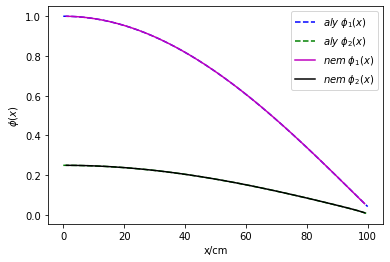

In [59]:
#analytical solver
[xa, phia, keff] = _analytical("UO2", 0.8)

#CMFD+NEM solver
CASE = ['UO2','UO2','UO2','UO2','UO2']
THICKNESS = [20, 20, 20, 20, 20]
bconl = 0 #reflective
bconr = 1 #vacuum
nmesh = 1 + 5 * 10
maxinner = 50
maxouter = 50
CritNDF  = 1E-8
CritK    = 1E-6
WSswitch = 1
lamdinit = 1
[xs, lamd, phis, Inner, Outer] = _CmfdNemSolver(CASE, THICKNESS, bconl, bconr, \
                                                nmesh, maxinner, maxouter, WSswitch, \
                                                CritK, CritNDF, lamdinit)

plt.plot(xa, phia[:,0], 'b--', label = "$aly \; \phi_1(x)$")
plt.plot(xa, phia[:,1], 'g--', label = "$aly \; \phi_2(x)$")
plt.plot(xs, phis[:,0]/phis[0][0], 'm-', label = "$nem \; \phi_1(x)$") #scale to 1
plt.plot(xs, phis[:,1]/phis[0][0], 'k-', label = "$nem \; \phi_2(x)$")
plt.yscale("linear")
plt.xlabel('x/cm')
plt.ylabel('$\phi(x)$')
plt.legend()
plt.show()


### Part B.2: homogeneous model--MOX

Analytically Estimated k-eff for UO2: [1.20394103]
outer: 1, inner: 10, keff: 1.203945483271615, lamderror: 6.828462784103095e-08, max_NDF_change: 143.75613321840186


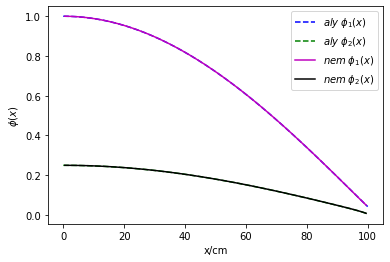

In [60]:

#analytical solver
[xa, phia, keff] = _analytical("UO2", 0.8)

#CMFD+NEM solver
bconl = 0 #reflective
bconr = 1 #vacuum
nmesh = 1 + 5 * 20
maxinner = 100
maxouter = 20
CritNDF  = 1E-6
CritK    = 1E-6
WSswitch = 1
lamdinit = 0.8
[xs, lamd, phis, Inner, Outer] = _CmfdNemSolver(CASE, THICKNESS, bconl, bconr, nmesh, maxinner, maxouter, WSswitch, CritK, CritNDF, lamdinit)

plt.plot(xa, phia[:,0], 'b--', label = "$aly \; \phi_1(x)$")
plt.plot(xa, phia[:,1], 'g--', label = "$aly \; \phi_2(x)$")
plt.plot(xs, phis[:,0]/phis[0][0], 'm-', label = "$nem \; \phi_1(x)$")
plt.plot(xs, phis[:,1]/phis[0][0], 'k-', label = "$nem \; \phi_2(x)$")
plt.yscale("linear")
plt.xlabel('x/cm')
plt.ylabel('$\phi(x)$')
plt.legend()
plt.show()


### Part C: heterogenous model

outer: 1, inner: 11, keff: 1.2021509228669642, lamderror: 1.4571181039535475e-08, max_NDF_change: 181.00571952995813


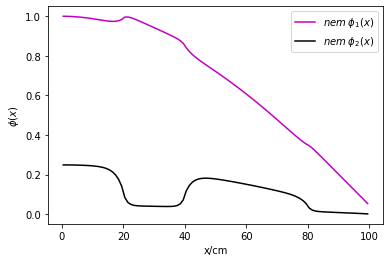

In [61]:

CASE = ['UO2','MOX','UO2','UO2','MOX']
THICKNESS = [20, 20, 20, 20, 20]
bconl = 0 #reflective
bconr = 1 #vacuum
nmesh = 1 + 5 * 20
maxinner = 50
maxouter = 20
CritPhi  = 1E-6
CritK    = 1E-6
WSswitch = 1
lamdinit = 0.8
[xs, lamd, phis, Inner, Outer] = _CmfdNemSolver(CASE, THICKNESS, bconl, bconr, nmesh, maxinner, maxouter, WSswitch, CritK, CritNDF, lamdinit)

plt.plot(xs, phis[:,0]/phis[0][0], 'm-', label = "$nem \; \phi_1(x)$")
plt.plot(xs, phis[:,1]/phis[0][0], 'k-', label = "$nem \; \phi_2(x)$")
plt.yscale("linear")
plt.xlabel('x/cm')
plt.ylabel('$\phi(x)$')
plt.legend()
plt.show()
